# Train an image classifier

This notebook demonstrates training a [Convolutional Neural Network (CNN)](https://www.ibm.com/topics/convolutional-neural-networks) to classify images. There'll be two options: 

 **Option 1** - Train a image classifier using Pinterest images we downloaded from the `01_download_images.ipynb` notebook.  
 **Option 2** - Train a sketch classifier using a small subset of Google's [Quick, Draw!](https://quickdraw.withgoogle.com/data) dataset.

It will take the following setps:

**Step 0** - Prepare images  
**Step 1** - Load your dataset  
**Step 2** - Create an empty neural network model  
**Step 3** - Train the model  
**Step 4** - Test and evaluate the training results  



Before we start, let's config the device PyTorch is using

In [155]:
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

elif torch.backends.mps.is_available():
    device = "mps"

print(f'Using device: {device}')

Using device: mps


## **Step 0** - Prepare images


Depending on your choice, follow either **option 1** or **option 2**.


### **Option 1** - Using Pinterest images we have downloaded  

Instructions for downloading Pinterest images can be found in the `01_download_images.ipynb` notebook.  


First, make sure you have sorted them into a main folder and respective category folders,   
e.g. in your `data` folder under week-3, you should have:  
```
./my_dataset/chairs/0001.jpg  <- the file name 001.jpg can be anything
./my_dataset/chairs/0002.jpg
...
./my_dataset/dogs/0001.jpg
./my_dataset/dogs/0002.jpg
...

```

Then, define some configurations for our dataset

In [156]:
# we're going to crop all images to this resolution
image_resolution = 64

# how many colour channels?
# 3 for RGB, 1 for greyscale
colour_channels = 3

# make sure the path to your image folder is correct
folder_path = '/Users/wh/Documents/msc/coding/ml/week-3/img'

Now we have finished Option 1, please skip to **Step 1** 




### **Option 2** - Using sketches from the QuickDraw! dataset


I prepared a small subset of Google's [Quick, Draw!](https://quickdraw.withgoogle.com/data) dataset in `../media/quick_draw_small.zip`. This subset contains 5000 greyscale drawings in `.jpg` format in 10 categories. 

If you choose this option, we'll build and train a model that can classify the category of these drawings.

#### Unzip the dataset folder and verify the data   

##### Mac / Linux users:

Use this command to unzip the dataset in the `data` folder:

In [157]:
# !unzip -q ../media/quick_draw_small.zip -d ./data

##### Windows users:  

Please manually unzip the `quick_draw_small.zip` file in the `data` folder

Now we should see the `quick_draw_small` folder, inside it should have ten folders with class names as folder names. Each folder should have 2000 drawings in `.jpg` format. 

Then, define some configurations for our dataset

In [158]:
# we're going to crop all images to this resolution
#image_resolution = 28

# how many colour channels?
# 3 for RGB, 1 for greyscale
#colour_channels = 1

# make sure the path to your image folder is correct
#folder_path = './data/quick_draw_small'


## **Step 1** - Load your dataset  

#### **1.1** - Pre-process images 

We need to pre-process (i.e. crop, resize, normalise) the images in our dataset.

We're going to use [PyTorch's Transforming functions](https://pytorch.org/vision/0.17/transforms.html) to define the pre-processes pipeline on our images. 

Refer to the documentation if you're unsure about some of the functions



In [159]:
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Grayscale, Resize, RandomCrop, Normalize

# this transformation function will help us pre-process images during the training (on-the-fly)
transformation = Compose([   
    # convert an image to tensor
    ToImage(),
    ToDtype(torch.float32, scale=True),
    
    # resize and crop
    Resize(image_resolution),
    RandomCrop(image_resolution),
    
    # normalise pixel values to be between -1 and 1 
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
    # if you're training on greyscale images, convert them to greyscale
    # otherwise just do nothing
    Grayscale() if colour_channels == 1 else torch.nn.Identity()
    
])

#### **1.2** - Create dataset loaders  

In order to load images during training, we're going to use something called "data loader".  
These data loaders loads images into batches according to the pre-processes pipeline we have defined previously.

We'll be using PyTorch's [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to create a training data loader and a testing data loader.  

> Note: If the following codes give you an error like `No module named 'sklearn'` or `No module named 'matplotlib'`, it means you have not yet installed matplotlib or sklearn. To install it, open up a terminal/command window, activate your environment (e.g., `conda activate coding3`), and then type `conda install matplotlib` and `conda install scikit-learn`

In [160]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch

from IPython.display import display

from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

In [161]:
# how many images are going to be put into the testing set, 
# e.g. 0.2 means 20% percent of images
test_size = 0.2 

# how many images will be used in one step of gradient descent, 
# this usually depend on your model / types of data / CPU or GPU's capability
batch_size = 16

There is a lot of discussion about how different batch sizes can affect training results, e.g. [here](https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/). But as a rule of thumb: larger batch sizes can make your gradient less noisy and therefore safer for larger learning rates, but this is always subjected to different models and data, especially when training generative models. So a good way to decide batch sizes is to follow literatures or similar works.

In [162]:
# Instatiate train and test datasets
train_dataset = ImageFolder(folder_path, transform=transformation)
test_dataset = ImageFolder(folder_path, transform=transformation)

# Get length of dataset and indicies
num_train = len(train_dataset)
indices = list(range(num_train))

# Get train / test split for data points
train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

# Override dataset classes to only be samples for each split
train_sub_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_sub_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Create training and tresing data loaders
train_loader = DataLoader(train_sub_dataset, batch_size=batch_size, num_workers=2, multiprocessing_context="forkserver" if device=='mps' else None, shuffle=True)
test_loader = DataLoader(test_sub_dataset, batch_size=batch_size, num_workers=2, multiprocessing_context="forkserver" if device=='mps' else None, shuffle=True)


In [163]:
# sort out the names for each classes (according to the folder names)
class_names = train_dataset.classes

print(f'{len(train_indices)} training images loaded')
print(f'{len(test_indices)} testing images loaded')
print(f'classes: {class_names}')


1070 training images loaded
268 testing images loaded
classes: ['architecture', 'duck', 'grass']


#### **1.3** - Visualise our data
Now we have the `train_loader` and the `test_loader` objects,  
We can use them to load and visualise some of our data


**Questions 1.3**: Use the following three lines of code to load a batch of training data and labels and print their shapes. What are the shapes of your `data` and `labels` variables? `data` and `labels` should be a 4-dimensional tensor and a 1-dimensional tensor. What does each dimension represent?

Hint: If you're unsure, have a look at the image tensor example from [last week's notebook](../week-2/pytorch_tensors_fundamentals.ipynb#Introduction-to-tensors)

In [164]:
data, labels = next(iter(train_loader))

print(f'data shape: {data.shape}')
print(f'labels shape: {labels.shape}')

data shape: torch.Size([16, 3, 64, 64])
labels shape: torch.Size([16])


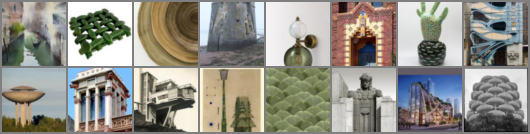

['0: duck', '1: grass', '2: duck', '3: architecture', '4: grass', '5: architecture', '6: grass', '7: architecture', '8: architecture', '9: architecture', '10: architecture', '11: architecture', '12: duck', '13: architecture', '14: architecture', '15: architecture']


In [165]:
# make a grid of images and display them

grid = make_grid(data, nrow = 8)
display(to_pil_image(grid.add(1).div(2)))

print([f'{i}: {class_names[class_name]}' for i, class_name in enumerate(labels)])

This is one batch of training data, it contains both the images and their categories, check if they match.

## **Step 2** - Load an empty neural network model   

We're going to skip over the details of how to setup a neural network model for now, they will be covered next week. If you want to have a sneak peek, feel free to check the `./src/model.py` file.  

For now, trust that the code makes a new neural network according to your dataset configurations.  
However, there're three important parameters:

 - `img_channel` defines the number of colour channels of inputs (1 for greyscale, 3 for RGB).
 - `img_resolution` defines the width and height of input images. 
 - `num_classes` defines how many categories we are classifying.

In [166]:
from src.model import ConvNeuralNetwork

In [167]:
model = ConvNeuralNetwork(img_channel = colour_channels, 
                          img_resolution = image_resolution,
                          num_classes = len(class_names))
model.to(device)

ConvNeuralNetwork(
  (convolutions): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

## **Step 3** - Train the model

#### **3.1** - Define optimiser and loss function

First, let's define an optimizer and the type of error (loss) function:
 - we use the `adam` optimizer
 - we use the `cross entropy loss` as our loss function 
 
This means: during the training process, the adam optimizer will try to minimise errors calculated by the cross entropy loss .

In [168]:
# Cross entropy loss
loss_function = torch.nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

#### **3.2** - Break and Recap

Up to this point, we have defined a lot of components for the model training.   
Let's recap what we have so far:
 - A training data loader `train_loader` and a testing data loader `test_loader` we defined in **Step 1**.
 - An empty neural network `model` we built in **Step 2**.
 - An optimizer `optimizer` and a loss function `loss_function` we just defined.

In the next step, we're going to program how they will coordinate during training. So...

#### **3.3** - Define training/ testing loop  

As an overview, each epoch has a training loop and a testing loop:   
In each training loop:
 - **Load**: The training data loader loads a batch of training data and their true class labels.
 - **Forward**: Forward pass the training data to our model, and get the predicted class labels.
 - **Loss**: Use the loss function to compares the predicted labels to the true labels, and compute the error.
 - **Optimise**: The optimizer slightly optimises our model based on the error computed by the loss function.

Once we finish a training loop, we do a testing loop. In a testing loop, we do exactly the same things as in a training loop, but we won't update our model. The testing results are only used to tell us how well the model is doing at the moment.

In each testing loop:
 - **Load**: The testing data loader loads a batch of testing data and their true class labels.
 - **Forward**: Forward pass the testing data to our model, and get the predicted class labels.
 - **Loss**: Use the loss function to compares the predicted labels to the true labels, and calculates the error.

In [169]:
# we can save the model regularly
save_every_n_epoch = 5

# total number of epochs we aim for
num_epochs = 20

# keep track of the losses, we can plot them in the end
train_losses = []
test_losses = []

print('Epoch 0')

for epoch in range(num_epochs): 

    #---- Training loop -----------------------------
    train_loss = 0.0
    model.train()
    
    for i, data in enumerate(train_loader, 0):
        # Load: The training data loader loads a batch of training data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)
        
        # Pass: Forward pass the training data to our model, and get the predicted classes.
        pred_labels = model(inputs)
        
        # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
        loss = loss_function(pred_labels, true_labels)
        train_loss += loss.item()
        
        # Optimise: The optimizer slightly optimises our model based on the error.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i % 50 == 0:
            print(f'  -> Step {i + 1:04}, train loss: {loss.item():.4f}')
    
    
    #---- Testing loop -----------------------------
    test_loss = 0.0
    model.eval()
    
    with torch.inference_mode():
        test_loss = 0.0
        for i, data in enumerate(test_loader, 0):
            # Load: The testing data loader loads a batch of testing data and their true class labels.
            inputs, true_labels = data
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)
            
            # Pass: Forward pass the testing data to our model, and get the predicted classes.
            pred_labels = model(inputs)
            
            # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
            loss = loss_function(pred_labels, true_labels)
            test_loss += loss.item()
    
    
    #---- Report some numbers -----------------------------
    
    # Calculate the cumulative losses in this epoch
    train_loss = train_loss / len(train_loader)
    test_loss = test_loss / len(test_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')
    
    # save our model every n epoch
    if (epoch+1) % save_every_n_epoch==0:
        torch.save(model.state_dict(), f'model_epoch{epoch:04}.pt')
        
# save the model at the end of the training process
torch.save(model.state_dict(), f'model_final.pt')

print("training finished, model saved to 'model_final.pt'")

Epoch 0
  -> Step 0001, train loss: 1.1300
  -> Step 0051, train loss: 1.1354
Epoch 1, train loss: 1.003, test loss: 0.973
  -> Step 0001, train loss: 0.9036
  -> Step 0051, train loss: 0.7744
Epoch 2, train loss: 0.886, test loss: 0.922
  -> Step 0001, train loss: 0.7723
  -> Step 0051, train loss: 0.7464
Epoch 3, train loss: 0.779, test loss: 0.778
  -> Step 0001, train loss: 0.4244
  -> Step 0051, train loss: 0.5475
Epoch 4, train loss: 0.715, test loss: 0.737
  -> Step 0001, train loss: 0.5646
  -> Step 0051, train loss: 0.9476
Epoch 5, train loss: 0.672, test loss: 0.753
  -> Step 0001, train loss: 0.8505
  -> Step 0051, train loss: 0.8439
Epoch 6, train loss: 0.653, test loss: 0.694
  -> Step 0001, train loss: 0.8782
  -> Step 0051, train loss: 0.5833
Epoch 7, train loss: 0.623, test loss: 0.617
  -> Step 0001, train loss: 0.6734
  -> Step 0051, train loss: 0.6697
Epoch 8, train loss: 0.624, test loss: 0.594
  -> Step 0001, train loss: 0.5897
  -> Step 0051, train loss: 0.8267
Ep

#### **3.4** - Plot Training Process

Plot how errors ("loss") change over time on the training set and the validation set

In [180]:
import matplotlib.pyplot as plt
import numpy as np

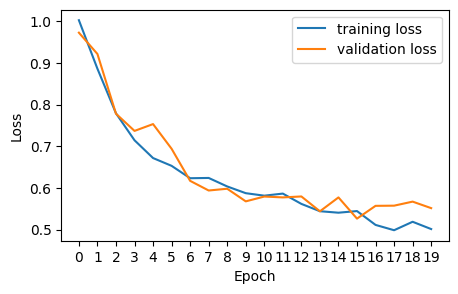

In [181]:
plt.figure(figsize=(5,3))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label = 'validation loss')
plt.xticks(np.arange(len(train_losses)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

**Question 3.4**: Could you describe the plotted lines in the figure, and explain what these lines indicate?

Your Answer: _____

## **Step 4** - Test and evaluate the training results   

#### **4.1** - Load model  
First, let's load our trained model. And set the model to 'evaluation' mode `.eval()` (check [torch.nn.Module.eval()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval))

In [172]:
from src.model import ConvNeuralNetwork

In [173]:
# make sure the parameters are the same as when the model is created
eval_model = ConvNeuralNetwork(img_channel = colour_channels, 
                          img_resolution = image_resolution,
                          num_classes = len(class_names))

# load the saved model, make sure the path is correct
eval_model.load_state_dict(torch.load('model_final.pt'))

eval_model.to(device)
eval_model.eval() 

ConvNeuralNetwork(
  (convolutions): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

#### **4.2** - Load some test data 

Data in the testing set has never been exposed to the model during the training process, so they are good to test if our model works fine on "new" data. Why? Because sometimes the model begins to **overfit** to the training set and is not able to "generalise" to data that are not in the training set.

In [184]:
test_data, test_labels = next(iter(test_loader))

true_label = class_names[test_labels[0]]

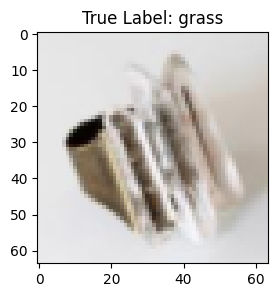

In [185]:
plt.figure(figsize=(3,3))
plt.title(f"True Label: {true_label}")
plt.imshow(test_data[0].add(1).div(2).permute((1,2,0)).cpu().detach().numpy())

plt.show()

Run it through a forward pass

In [176]:
with torch.inference_mode():
    pred_labels = eval_model(test_data.to(device))

#### **4.3** - Visualise the output

`pred_labels` is our model's output. It's not a single class label, instead, it's a set of (unnormalized) probabilities indicating how likely the drawing belongs to a class.  

We can use the following codes to plot these probabilities.

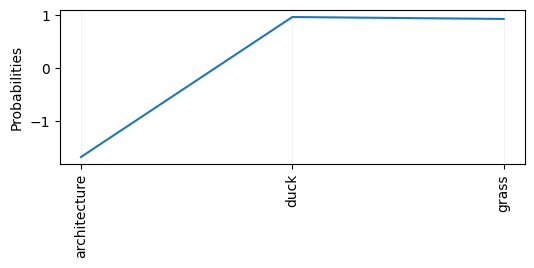

In [177]:
plt.figure(figsize=(6,2))
plt.plot(pred_labels[0].cpu().detach().numpy())
plt.xticks(np.arange(len(class_names)),class_names, rotation='vertical')
plt.ylabel("Probabilities")
plt.grid(axis='x', color='0.95')
plt.show()

I trained a sketch recognition model and I'm using this sketch as the input:


<img src='./src/graphics/test_plot.png' width='100px'></img>

And the codes above output this:

<img src='./src/graphics/prob_plot.png' width='500px'></img>

In my example, the category with the highest probability is "fish", which means that the model "thinks" this sketch is probably a fish.   
The second highest probability is "whale", indicating the model "thinks" it may also be a whale (this make sense because sketches of fish and whale may looks similar).

**Question 4.3:** What is the input image you're using? And what are the predicted probabilities? It's okay if it outputs an incorrect prediction, if this happens, could you guess why?

Your Answer: ____

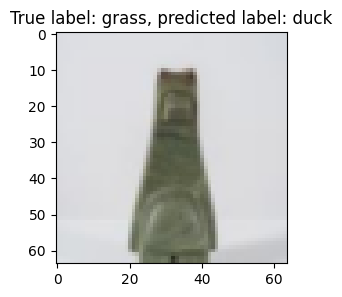

In [178]:
_, predicted_class_index = torch.max(pred_labels[0], 0)

plt.figure(figsize=(3,3))
plt.title(f"True label: {true_label}, predicted label: {class_names[predicted_class_index]}")
plt.imshow(test_data[0].add(1).div(2).permute((1,2,0)).cpu().detach().numpy())

plt.show()

#### **4.4** - Calculate accuracy  

Now we can run our model on the full testing set to calculate the accuracy of our model.  
In practice, we'll keep counting the correct predictions and check what percentage of the predictions are correct.

In [179]:
num_samples = 0
num_correct = 0

with torch.inference_mode():
    for i, data in enumerate(test_loader, 0):
        # Load: The testing data loader loads a batch of testing data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)

        # Pass: Forward pass the testing data to our model, and get the predicted classes.
        pred_labels = eval_model(inputs)
        pred_labels = torch.argmax(pred_labels, dim=1)
        
        num_correct += pred_labels.size(0) - torch.count_nonzero(pred_labels - true_labels)
        num_samples += pred_labels.size(0) 
        
accuracy = num_correct / num_samples
print(f'correct samples: {num_correct}  \ntotal samples: {num_samples}  \nmodel accuracy: {accuracy:.3f}')

correct samples: 184  
total samples: 268  
model accuracy: 0.687
